Homeowrk 3

CS 588 Intro to Big Data Fundamentals

October 16, 2020

Paul Abers

Question 1)

a)

In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')

Import and read in the iris dataset

In [2]:
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
convert_species = np.vectorize(lambda x : "setosa" if x==0 else ("versicolor" if x==1 else "virginica"))
iris_unnamed = iris_df
iris_df["target"] = convert_species(iris.target)
iris_unnamed["target"] = iris.target

In [85]:
iris_unnamed.head()

In [86]:
iris_df.head()

Import and read in the indian pines dataset

In [5]:
indian = loadmat(os.path.join(os.getcwd(), "indianR.mat"))
data = np.array(indian["X"]).T
targets = np.array(indian["gth"])[0]
indian_df = pd.DataFrame(data=data)
indian_df["target"] = targets

In [87]:
np.unique(indian_df["target"], return_counts=True)

In [88]:
iris_df.head()

In [89]:
indian_df.describe()

In [9]:
indexDrop = indian_df[indian_df["target"] == 0].index
indian_df.drop(indexDrop, inplace=True)
indian_df.reset_index(inplace=True)

In [90]:
indian_df.describe()

Both indian and iris datasets have successfully been loaded. Now, we need to setup PCA and LDA

First is PCA. PCA needs to scale the data first and then deconstruct the data into its principal components

In [12]:
def scale(df, scaler="MinMax"):
    """Scale the dataframe using the scaler specified and return the newly scaled dataframe
    """
    inputs = df.iloc[:, :-1].to_numpy()
    if scaler == "MinMax":
        scale = MinMaxScaler()
    elif scaler == "Standard":
        scale = StandardScaler()
    else:
        raise ValueError(f"Unsupported scaler {scaler}")
    scale.fit(inputs.astype(float))
    inputs = scale.transform(inputs)
    
    scaled_df = pd.DataFrame(data=inputs)

    scaled_df["target"] = df["target"]
    
    return scaled_df

In [13]:
def fit_pca(df, **kwargs):
    """Apply and return the prinicpal component fit for the dataframe
    """
    n_components = kwargs.get("n_components", len(df.columns)-1)
    
    inputs = df.iloc[:, :-1].to_numpy()
    
    pca = PCA(n_components=n_components)
    pc = pca.fit(inputs)
    
    return pc

In [14]:
def transform_pca(df, pc):
    """Use the given principal component fit to transform the dataframe and return the transformed dataframe
    """
    inputs = df.iloc[:, :-1].to_numpy()
    transformed_df = pd.DataFrame(data=pc.transform(inputs))
    transformed_df.columns = [*map(lambda y : f"PC-{y}", list(range(1, pc.n_components + 1)))] 
    transformed_df["target"] = df["target"]
    return transformed_df

In [119]:
def plot_variance(pc, n_components=None, figure_count=1):
    """Plot the explained variance ratio for the principal component fit
    """
    
    pc_cols = lambda x : [*map(lambda y : f"PC-{y}", list(range(1, x+1)))]
        
    n_comps = n_components if n_components is not None else pc.n_components
        
    plt.figure(figsize=(18,8))
    plt.style.use("ggplot")
    plt.rcParams.update({'font.size': 18})
    plt.bar(pc_cols(n_comps), pc.explained_variance_ratio_[:n_comps])
    plt.title("Explained Variance Ratio vs. Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.xlabel(f"Principal Component\nFigure: {figure_count}")
    plt.ylim([0, 1.1])
    return figure_count + 1

In [118]:
def plot_pca_lda(df, **kwargs):
    """Plot the dataframes first two components and color the target classes accordingly
    
    Can also plot the first two eigenvectors if requested.
    """
    title = kwargs.get("title", "Plot of Data With First Two Components")
    xlabel = kwargs.get("xlabel", "First Component")
    ylabel = kwargs.get("ylabel", "Second Component")
    eigens = kwargs.get("eigens", None)
    alpha = kwargs.get("alpha", 0.75)
    figure_count = kwargs.get("figure_count", 1)
    
    labels = np.unique(df["target"])
    
    fig = plt.figure(figsize=(18,8))
    plt.style.use("ggplot")
    plt.rcParams.update({'font.size': 18})
    #fig, ax = plt.subplots(1,1, figsize=(18,12), style="ggplot")
    ax = fig.add_subplot(111)
    ax.set_xlabel(f"{xlabel}\nFigure: {figure_count}")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'r', 'g', 'b', 'y', 'm', 'c', 'k', 'r', 'g', 'b']
    markers = ['o', 'o', 'o', 'o', 'o', 'o', '*', '*', '*', '*', '*', '*', '+', '+', '+', '+', '+']
    for i, label in enumerate(labels):
        first_two = df.loc[df["target"] == label].iloc[:, 0:2].to_numpy()
        ax.scatter(first_two[:, 0], first_two[:, 1], label=label, alpha=alpha, color=colors[i], marker=markers[i])
        
    if eigens is not None:
        eig_vec = eigens[0][:2]
        eig_val = eigens[1][:2]
        for vec, val in zip(eig_vec, eig_val.T):
            ax.plot([0, np.sqrt(vec)*val[0]], [0, np.sqrt(vec)*val[1]], "k-", lw=2)
        
    ax.legend()
    return figure_count + 1

In [107]:
def get_eigens(df, n_components=None):
    """Get the eigen values and eigen vectors for the given data
    """
    inputs = df.iloc[:, :-1].to_numpy()
    cov = np.cov(inputs.T)
    eig_vec, eig_val = np.linalg.eig(cov)
    if n_components is None:
        print(f"Eigen Values:\n{eig_val}")
        print(f"Eigen Vectors:\n{eig_vec}")
    else:
        print(f"Eigen Values:\n{eig_val[:n_components]}")
        print(f"Eigen Vectors:\n{eig_vec[:n_components]}")
    
    return eig_vec, eig_val

In [18]:
def perform_pca(df, **kwargs):
    """Single function call to scale, fit and transform the data with pca
    """
    df_scaled = scale(df)
    pc = fit_pca(df_scaled, **kwargs)
    df_pca = transform_pca(df_scaled, pc)
    
    return df_pca

Now to create the same functionality for LDA.

In [120]:
def perform_lda(df, **kwargs):
    """Perform linear discriminant analysis on the data and returned the transformed data
    """
    n_components = kwargs.get("n_components", len(np.unique(df["target"].values))-1)
    
    inputs = df.iloc[:, :-1].to_numpy()
    targets = np.array(df["target"].values)

    lda = LinearDiscriminantAnalysis(n_components=n_components)
    transform_df = pd.DataFrame(data=lda.fit(inputs, targets).transform(inputs))
    transform_df["target"] = df["target"]
    
    return transform_df

Now that all the functions are written, just call the variance functions to create the plots and outputs for the iris and indian datasets.

In [121]:
figure_count = 1

Explained Variance Ratio:
[0.84136038 0.11751808 0.03473561 0.00638592]
Eigen Values:
[[ 1.00000000e+00  2.27117367e-16  1.58067971e-16  8.17929707e-17]
 [ 0.00000000e+00  1.00000000e+00 -3.34545298e-16 -3.45648222e-17]
 [ 0.00000000e+00  3.46217222e-16  1.00000000e+00  8.87035040e-17]
 [ 0.00000000e+00  4.27653296e-17 -1.11519743e-16  1.00000000e+00]]
Eigen Vectors:
[0.23245325 0.0324682  0.00959685 0.00176432]


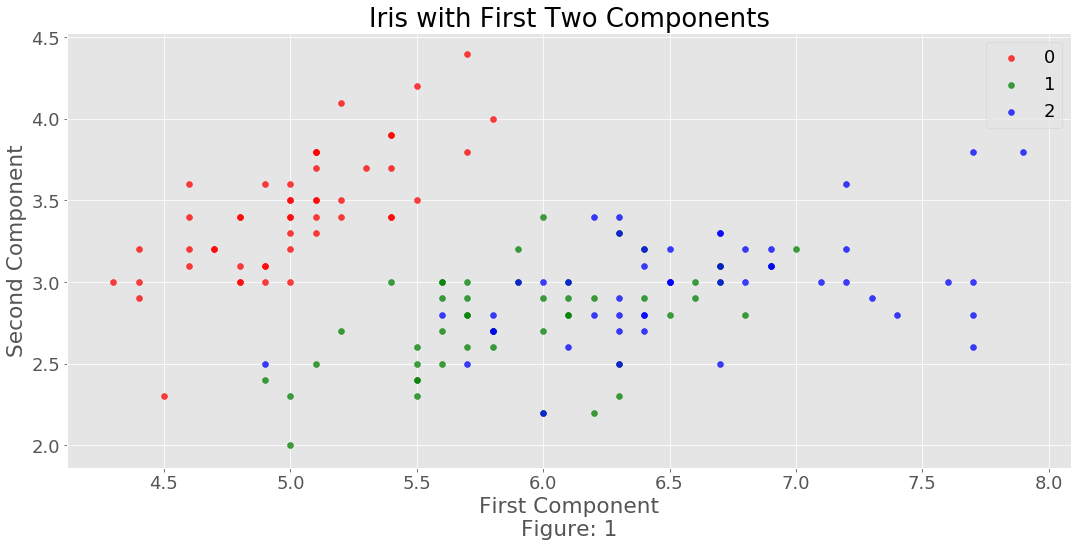

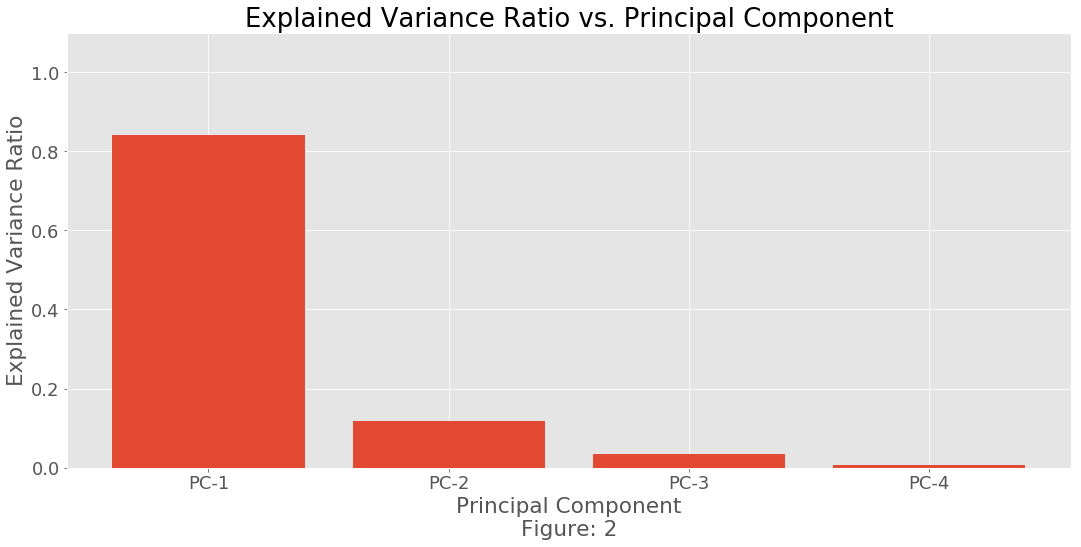

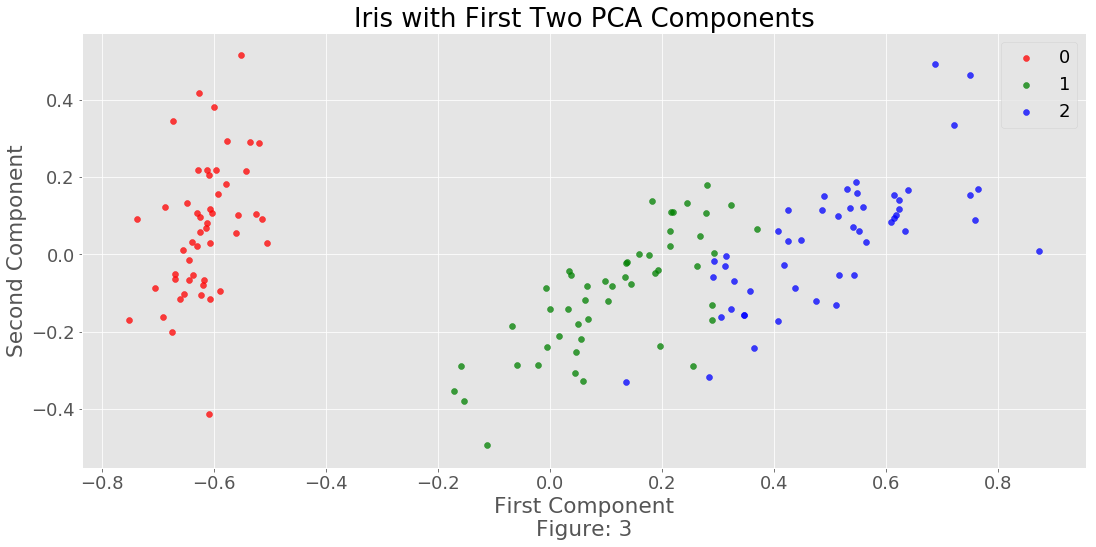

In [122]:
figure_count = plot_pca_lda(iris_df, title="Iris with First Two Components", figure_count=figure_count)
iris_scaled = scale(iris_df)
pc = fit_pca(iris_scaled)
print(f"Explained Variance Ratio:\n{pc.explained_variance_ratio_}")
figure_count = plot_variance(pc, figure_count=figure_count)
iris_pc = transform_pca(iris_scaled, pc)
eigens = get_eigens(iris_pc)
figure_count = plot_pca_lda(iris_pc, title="Iris with First Two PCA Components", figure_count=figure_count)

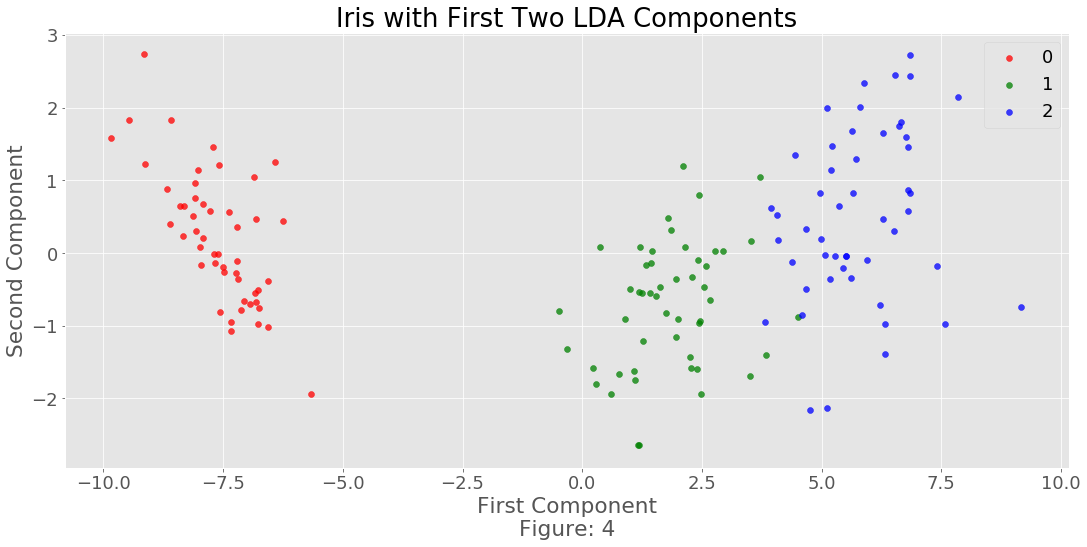

In [123]:
iris_lda = perform_lda(iris_df)
figure_count = plot_pca_lda(iris_lda, title="Iris with First Two LDA Components", figure_count=figure_count)

In [110]:
figure_count = 5

Explained Variance Ratio:
[0.84769736 0.0979396  0.01467606 0.00926067 0.00496592 0.00250275
 0.00205987 0.00193326 0.00187837 0.00145054]
Eigen Values:
[[-1.00000000e+00  1.23193241e-14  1.50799398e-16 -5.05373571e-17
  -1.86533643e-16  1.69168157e-17  4.17139303e-17 -6.52632864e-18
   2.19383075e-17 -4.87640046e-18]
 [ 1.21604305e-14  1.00000000e+00 -2.28121653e-15 -5.33026910e-16
  -3.03943213e-17 -4.76259399e-17 -1.22450817e-16 -1.53057642e-16
   9.09176230e-17  4.93119258e-18]
 [ 1.50764889e-16  2.26044742e-15  1.00000000e+00  6.64122185e-16
   6.03282370e-16 -2.32365639e-17 -1.38448512e-16 -1.05106398e-16
  -4.21610797e-17  6.05635344e-17]
 [ 5.05335101e-17 -3.58546763e-16  2.02124508e-16 -1.00000000e+00
  -1.54773689e-17 -2.59837088e-17  7.50888526e-16 -2.78110471e-17
   1.04758763e-16 -1.97850752e-16]
 [-1.86531162e-16  4.24795145e-17 -6.30023876e-16 -3.89974121e-16
   1.00000000e+00 -2.57441911e-14  2.81385894e-13 -4.44992591e-15
   4.52394495e-15 -9.35150739e-15]
 [-1.6916806

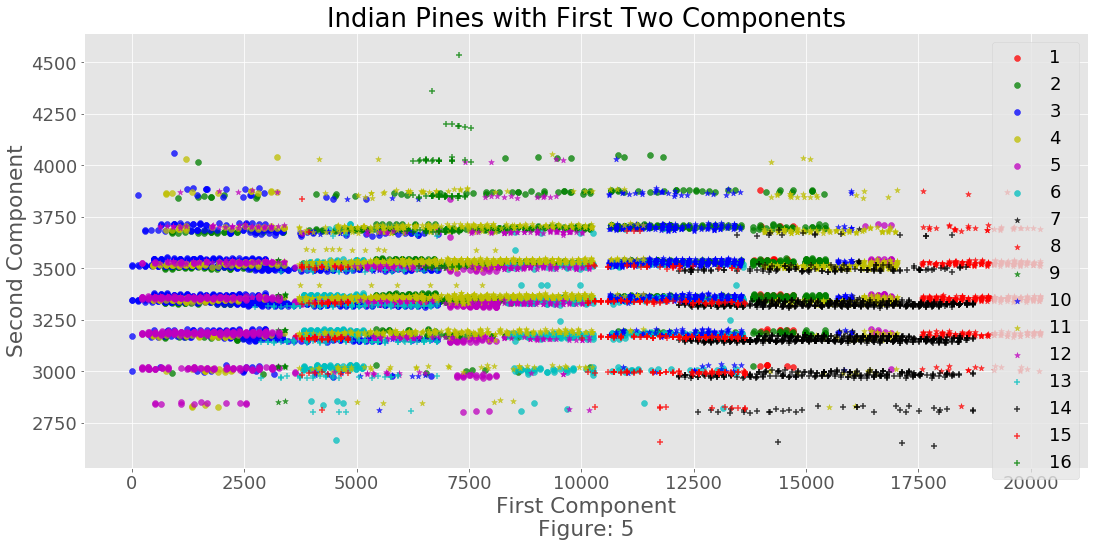

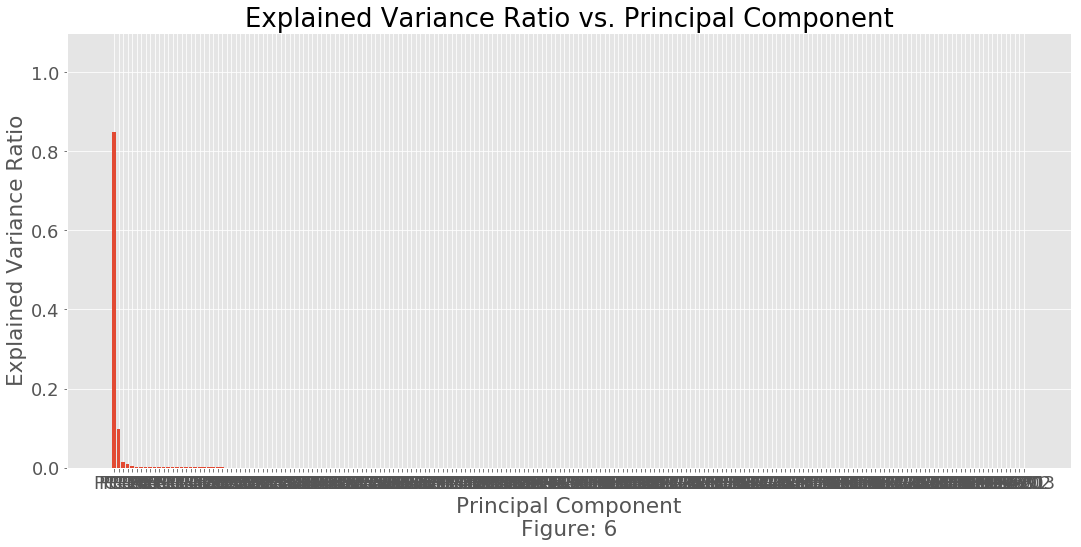

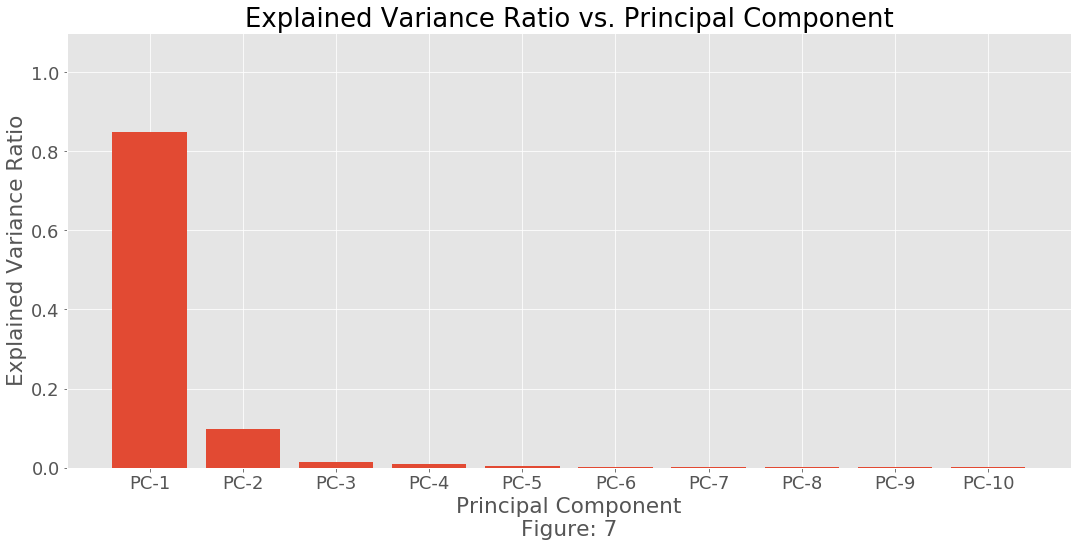

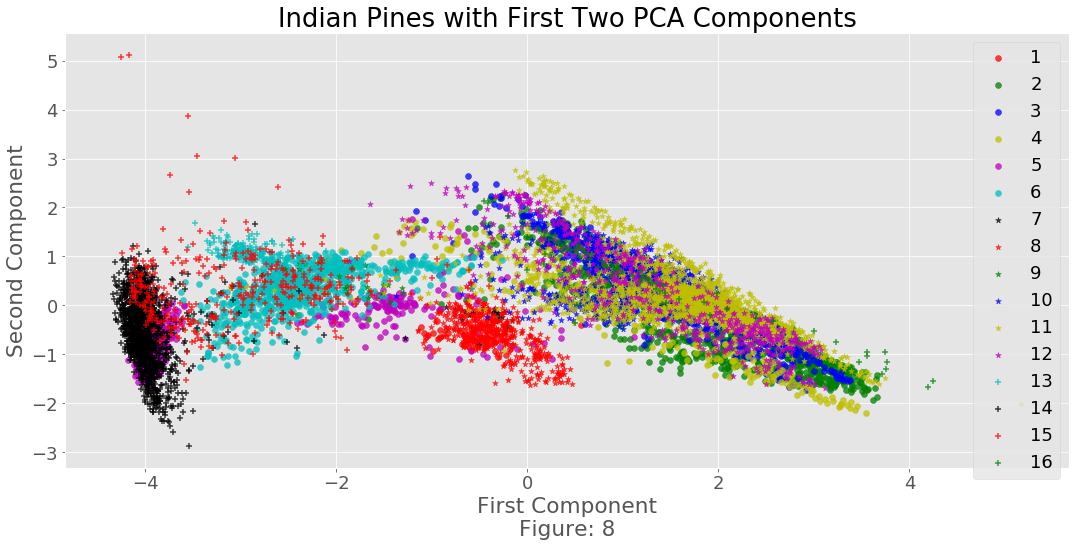

In [124]:
figure_count = plot_pca_lda(indian_df, title="Indian Pines with First Two Components", figure_count=figure_count)
indian_scaled = scale(indian_df, scaler="MinMax")
pc = fit_pca(indian_scaled)
figure_count = plot_variance(pc, figure_count=figure_count)
pc = fit_pca(indian_scaled, n_components=10)
print(f"Explained Variance Ratio:\n{pc.explained_variance_ratio_}")
figure_count = plot_variance(pc, n_components=10, figure_count=figure_count)
indian_pc = transform_pca(indian_scaled, pc)
eigens = get_eigens(indian_pc)
figure_count = plot_pca_lda(indian_pc, title="Indian Pines with First Two PCA Components", figure_count=figure_count)

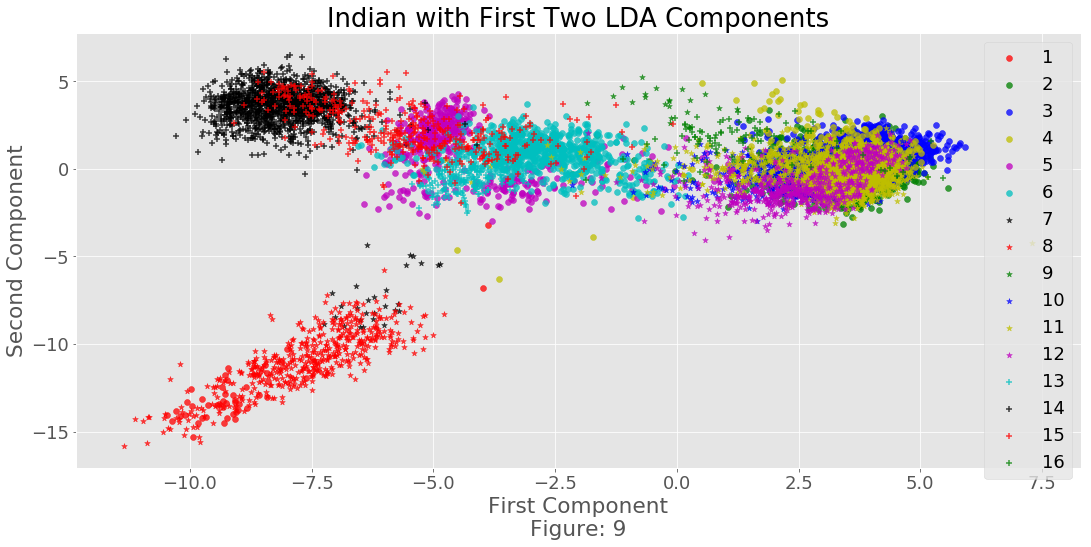

In [125]:
indian_lda = perform_lda(indian_df, n_components=2)
figure_count = plot_pca_lda(indian_lda, title="Indian with First Two LDA Components", figure_count=figure_count)

b)

The three plots of the first two components with no, pca and lda dimenstionality reduction for both the iris and indian datasets demonstrate the usefulness of dimensionality reduction and preojection. First, with the iris, with no projection there is a lot of overlap between the first and second classes. It is not clear how to delineate between the two. After performing either LDA or PCA, the separability because much clearer and easier. This separation also only requires two components/dimensions to be readily apparent. This is further supported by the variances plot which shows that the first two principal components contain over 90% of the iris' data variance. 

Looking at the indian pines dataset and plots we see a similar pattern. The first plot shows no dimensionality reduction or projection. There is a lot of overlap between classes. Note that this plot just shows the first two components of the data, and not the best two. The PCA's and LDA's first two components do a much better job of separating the classes. There is still overlap between classes in the plot but we are starting to separate the classes out. It is not surprising that there is still some overlap between the data since we are only taking 2 of 202 components to try and separate all the data. However, the first two components show significant improvement and could make things much better once including several more components. From the variance plot, we see once again that the first two principal components are able to capture over 90% of the indian's data variance. This suggests we can severely decrease the number of components from 202 to a much more reasonable number. This should greatly reduce runtimes of learners on the data (as demonstrated later in question two).

The number of principal components to use for the classifiers seems to suggest 2 for the iris dataset, and possibly around 5-10 for the indian. We only need two for the iris because we can already see the three classes are separated in its plot. However, the indian dataset, while improved, would still need more components since the classes are not able to be completely separated with just the first two components. The same could be said for the LDA analyses.

The LDA and PCA worked about the same for the iris dataset. Most likely since it is a simple dataset and the variance does a good job of explaining the data's separate classes. The LDA appears to perform better on the indian dataset. PCA still works but there appears to still be significant overlap in some regions. The explained varaince plot also shows that minimal variance is explained by principal components greater than 2, but we can see from our plot that we will need more than just two principal components to explain the data. LDA seems to perform slightly better. This is most likely because it is able to take the classes into consideration when finding the best basis for projection to increase separability. PCA can sometimes struggle because it looks for overall variances, and does not consider intra- and inter- class means and variances.

Question 2)

a)

Import the needed modulse for classification

In [24]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import time

In [25]:
def perform_classification(df_data, model, test_size):
    """Perform claaification on the data using the model and test size given.
    
    Returns a dictionary for the results of the classification
    """
    def split_data(df, test_size):
        """split the data into test and train
        """
        X = df.iloc[:, :-1].to_numpy()
        y = df["target"].to_numpy()
        return train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True)

    X_train, X_test, Y_train, Y_test = split_data(df_data, test_size)
    
    
    model.fit(X_train, Y_train)
    predict_train = model.predict(X_train)
    
    predict_test = model.predict(X_test)
    
    return {"predict_train": predict_train,
            "predict_test": predict_test,
            "train": Y_train,
            "test": Y_test
           }

In [26]:
def perform_performance(classifications):
    """Determine the performance of the classifier for several metrics 
    (sensitivity, specificity, accuracy and a confusion matrix) for both
    test and train data.
    """
    def get_spec_sens(confusion_matrix):
        """Use the confusion matrix to determine the specificity and sensitivity
        for the classifier for each possible target class.
        """
        specificities = []
        sensitivities = []
        # Loop over the target classes
        for iLabel in list(range(len(confusion_matrix))):
            # set the 4 false/true/pos/neg to zero
            tp, tn, fn, fp = 0, 0, 0, 0
            # loop over all rows and columns
            for i in range(len(confusion_matrix)):
                for j in range(len(confusion_matrix)):
                    if j == iLabel and i == j:
                        # a true positive is on the diagonal and for the specific target class
                        tp += confusion_matrix[i, j]
                    elif j == iLabel:
                        # a false positive has the same predicted class but wrong actual class
                        fp += confusion_matrix[i, j]
                    elif iLabel == i:
                        # a false negative has the same actual class but wrong predicted class
                        fn += confusion_matrix[i, j]
                    else:
                        # a true negative is all else 
                        tn += confusion_matrix[i, j]
            sensitivity = tp / (tp+fn)
            specificity = tn / (tn+fp)
            sensitivities.append( sensitivity)
            specificities.append( specificity)
    
        return specificities, sensitivities
    
    def get_score(actual, predictions):
        """Get the classification accuracy for the predictions
        """
        correct = 0
        for i in range(len(actual)):
            if actual[i] == predictions[i]:
                correct += 1
        return correct / len(actual)
    
    def confusion_matrix(actual, predict, targets):
        """Get the confusion matrix for the predictions
        """
        def get_target_index(target):
            """determine the target index for placement in the confusion matrix
            """
            for i in range(len(targets)):
                if targets[i] == target:
                    found = True
                    break
            if found == False:
                raise ValueError(f"Target {target} not found in targets {targets}")
            return i
        
        #initialize conusion matrix
        conf_mat = np.zeros((len(targets), len(targets)), dtype=int)
        #loop over each prediction
        for i in range(len(actual)):
            #the row of the confusion matrix
            iActual = get_target_index(actual[i])
            #the col of the confusion matrix
            iPredict = get_target_index(predict[i])
            # add one to the row and col position of the confusion matrix
            conf_mat[iActual, iPredict] += 1
            
        return conf_mat
    
    #create the dictionary for all the performance attributes
    performance = {}
    targets = np.unique(list(np.unique(classifications["train"])) + list(np.unique(classifications["test"])))
    performance["conf_mat_train"] = confusion_matrix(classifications["train"], classifications["predict_train"], targets)
    performance["specificity_train"], performance["sensitivity_train"] = get_spec_sens(performance["conf_mat_train"])
    performance["accuracy_train"] = get_score(classifications["train"], classifications["predict_train"])
    
    performance["conf_mat_test"] = confusion_matrix(classifications["test"], classifications["predict_test"], targets)
    performance["specificity_test"], performance["sensitivity_test"] = get_spec_sens(performance["conf_mat_test"])
    performance["accuracy_test"] = get_score(classifications["test"], classifications["predict_test"])
    
    return performance

In [136]:
def print_conf_mat(conf_mat, labels):
    """A pretty printer for the confusion matrix
    """
    spacer=4
    width = " "*spacer
    print("Act /" + "    Predictions  ")
    
    line = "  "
    for label in labels:
        line += "|" + label
    print(line)
    for i, label in enumerate(labels):
        line = label[:2]
        for j in range(len(conf_mat)):
            line += f"|{conf_mat[i,j]:<4}"
        print(line)

In [98]:
def get_targets(dataset, targets):
    """A function to get the targets to help with the pretty printing of confusion matrix
    """
    def convert(val):
        if val == 0:
            ret = "Seto"
        elif val == 1:
            ret = "Vers"
        else:
            ret = "Virg"
        return ret
            
    ret_targets = np.empty(len(targets), dtype=object)
    if dataset == "iris":
        for i in range(len(targets)):
            ret_targets[i] = convert(targets[i])
    else:
        for i in range(len(targets)):
            ret_targets[i] = str(targets[i]).ljust(2)
    return ret_targets

In [78]:
def run_model(dataset, df, model, testing_sizes):
    """Run the model on the dataframe using the model and test size given
    
    return the performance of the model
    """
    def get_training_sizes(testing_sizes):
        """Get the training size array
        
        training size is just 1-test size
        """
        training_sizes = []
        for i in range(len(testing_sizes)):
            training_size = np.round((1-testing_sizes[i])*10)/10
            training_sizes.append(training_size)
        return training_sizes
    
    # setup the output dictionary
    output = {}
    start = time.time()
    output["targets"] = get_targets(dataset, np.unique(df.target))
    output["specs_train"] = np.zeros((len(testing_sizes), len(output["targets"])))
    output["senss_train"] = np.zeros((len(testing_sizes), len(output["targets"])))
    output["specs_test"] = np.zeros((len(testing_sizes), len(output["targets"])))
    output["senss_test"] = np.zeros((len(testing_sizes), len(output["targets"])))
    output["train_scores"] = []
    output["test_scores"] = []
    output["training_sizes"] = get_training_sizes(testing_sizes)
    
    #loop over the test sizes and add the performances to the output dictionary
    for i, size in enumerate(testing_sizes):
        #print(size)               
        classifications = perform_classification(df, model, size)
        performance = perform_performance(classifications)
        
        output["test_scores"].append(performance["accuracy_test"])
        output["train_scores"].append(performance["accuracy_train"])
        output["specs_train"][i, :] = performance["specificity_train"]
        output["senss_train"][i, :] = performance["sensitivity_train"]
        output["specs_test"][i, :] = performance["specificity_test"]
        output["senss_test"][i, :] = performance["sensitivity_test"]
        if size == 0.7:
            output["conf_mat_train"] = performance["conf_mat_train"]
            output["conf_mat_test"] = performance["conf_mat_test"]
    output["runtime"] = time.time() - start        
    return output

All the functions are setup, now setup the inputs and loop over all the different combinations to generate the performances of the classifiers.

Setup the models to be used.

In [30]:
testing_sizes = np.array([*range(90, 0, -10)])/100
models = {}
models["svm_rbf"] = SVC(kernel="rbf", gamma="auto")
models["svm_poly"] = SVC(kernel="poly", gamma="auto")
models["svm_linear"] = SVC(kernel="linear", gamma="auto")
models["knn"] = KNeighborsClassifier()
models["naive_bayes"] = GaussianNB()

Setup the datasets to use, and apply the necessary dimensionality reduction.

In [84]:
iris_pca = perform_pca(iris_unnamed, n_components=2)
iris_lda = perform_lda(iris_unnamed, n_components=2)
indian_pca = perform_pca(indian_df, n_components=4)
indian_lda = perform_lda(indian_df, n_components=15)
dfs = {"iris_PCA_2": iris_pca,
      "iris_LDA_2": iris_lda,
      "iris_None_None": iris_unnamed,
      "indian_PCA_4": indian_pca,
      "indian_LDA_15": indian_lda,
      "indian_None_None": indian_df
    }

Run the models

In [83]:
#initialize the dictionary for catching all the various model outputs
total_output = {}
# loop over each dataframe
for key, df in dfs.items():
    data, dim_red, dim_num = key.split("_")
    # intialize sub dictionary for each classifier performance
    output_classifier = {}
    #loop over each model and save performance to the sub dictionary for classifiers
    for classifier, model in models.items():
        #print(f"==== {data} - {classifier} - {dim_red} ====")
        output_classifier[classifier] = run_model(data, df, model, testing_sizes)
    #add sub dictionary for classification to our total dictionary
    total_output[key] = output_classifier
    
#print("finished")

I chose to save the output as the runtime was quite significant. The next two cells do not always need to be ran.

In [34]:
import pickle

pickle_file = open(os.path.join(os.getcwd(), "total_output.p"), "wb")

pickle.dump(total_output, pickle_file)

In [127]:
pickle_file_read = open(os.path.join(os.getcwd(), "total_output.p"), "rb")
total_output_pickle = pickle.load(pickle_file_read)

Plot the run times for each of the datasets and classifiers

In [116]:
figure_count = 10

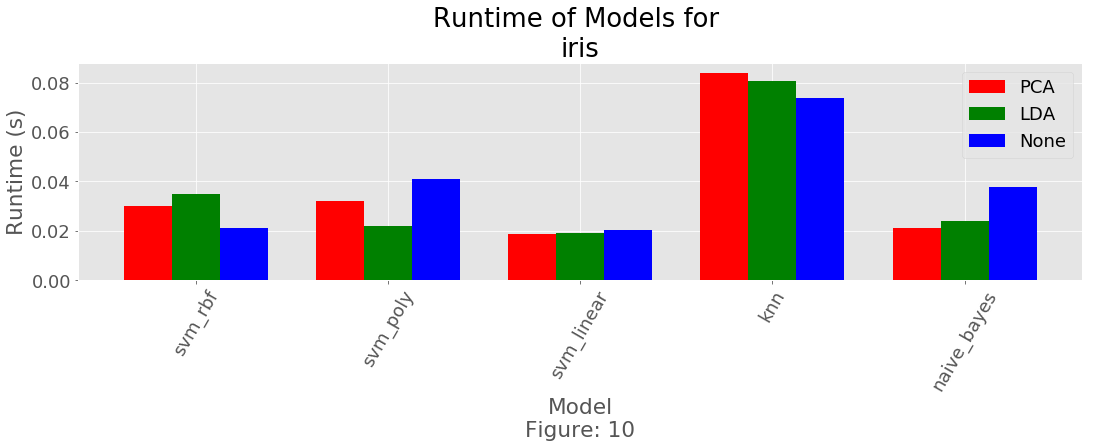

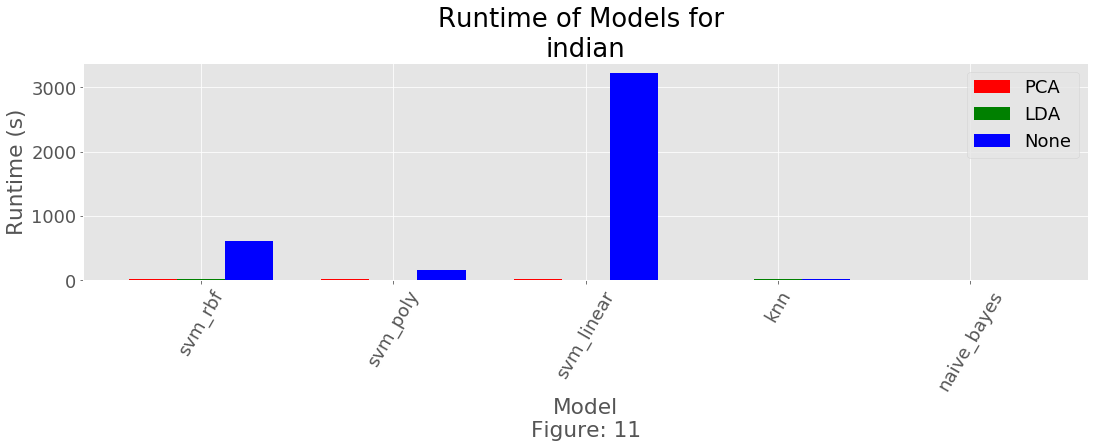

In [117]:
for dataset in ["iris", "indian"]:
    count = 0
    fig = plt.figure(figsize=(18,4))
    ax = fig.add_subplot(111)
    ax.set_title(f"Runtime of Models for \n{dataset}")
    ax.set_xlabel(f"Model\nFigure: {figure_count}")
    ax.set_ylabel("Runtime (s)")
    colors = ["r", "g", "b"]
    for key, df in dfs.items():
        data, dim_red, dim_num = key.split("_")
        if data != dataset:
            continue
        runtimes = []
        classifiers = []
        for classifier, model in models.items():
            runtimes.append(total_output_pickle[key][classifier]["runtime"])
            classifiers.append(classifier)
        X = np.arange(len(classifiers))
        ax.bar(X -0.25 + count*0.25, runtimes, color=colors[count], width=0.25, label=dim_red)
        count +=1
    classifiers = [""] + classifiers
    ax.set_xticklabels(classifiers, Rotation=60)
    ax.legend()
    figure_count += 1
        
        

In [40]:
def get_header(data, dim_red, dim_num, classifier, length):
    """Create the header for the confusion matrices
    """
    mid = f" {data} - {dim_red} - {dim_num} - {classifier} "
    excess = length - len(mid)
    if excess > 0:
        output = "=" * (excess // 2 + excess % 2)
        output += mid
        output += "=" * (excess // 2)
    else:
        output = mid
    return output

Loop over all the classifiers and performance and generate the plots and confusion matrices.

In [138]:
figure_count = 12

========= iris - LDA - 2 - svm_rbf =========
======       Train Size: 30%         =======
----      Training Confusion Matrix     ----
Act /    Predictions  
  |Seto|Vers|Virg
Se|10  |0   |0   
Ve|0   |17  |0   
Vi|0   |0   |18  
----      Testing Confusion Matrix      ----
Act /    Predictions  
  |Seto|Vers|Virg
Se|40  |0   |0   
Ve|0   |29  |4   
Vi|0   |0   |32  
======== indian - LDA - 15 - svm_rbf =======
======       Train Size: 30%         =======
----      Training Confusion Matrix     ----
Act /    Predictions  
  |1   |2   |3   |4   |5   |6   |7   |8   |9   |10  |11  |12  |13  |14  |15  |16  
1 |15  |0   |0   |0   |0   |0   |0   |0   |0   |0   |0   |0   |0   |0   |0   |0   
2 |0   |410 |5   |0   |0   |0   |0   |0   |0   |7   |12  |1   |0   |0   |0   |0   
3 |0   |9   |219 |2   |0   |0   |0   |0   |0   |0   |11  |1   |0   |0   |0   |0   
4 |0   |0   |1   |58  |0   |0   |0   |0   |0   |0   |0   |0   |0   |0   |0   |0   
5 |0   |0   |0   |0   |152 |1   |0   |0   |0   |0   |0   

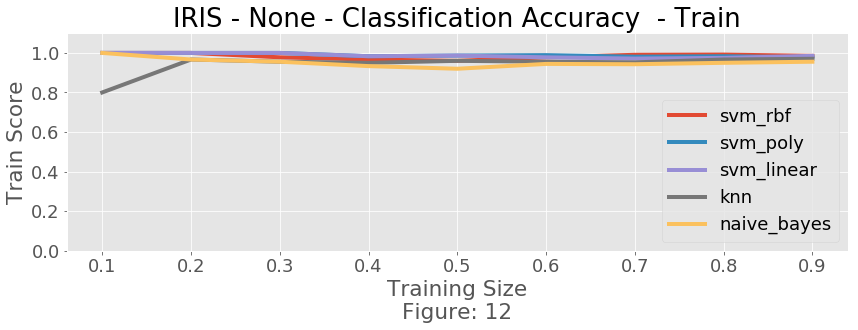

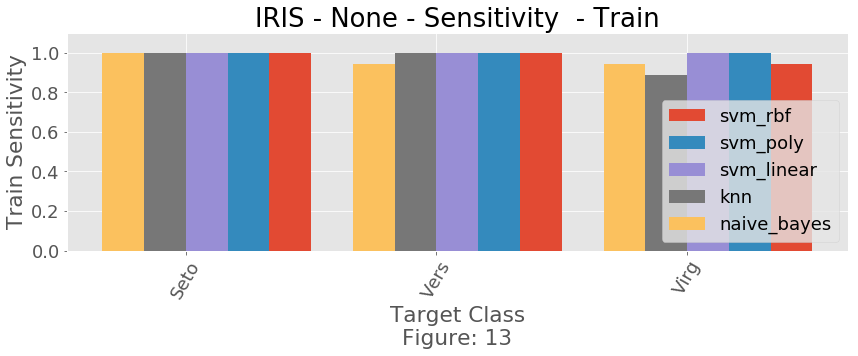

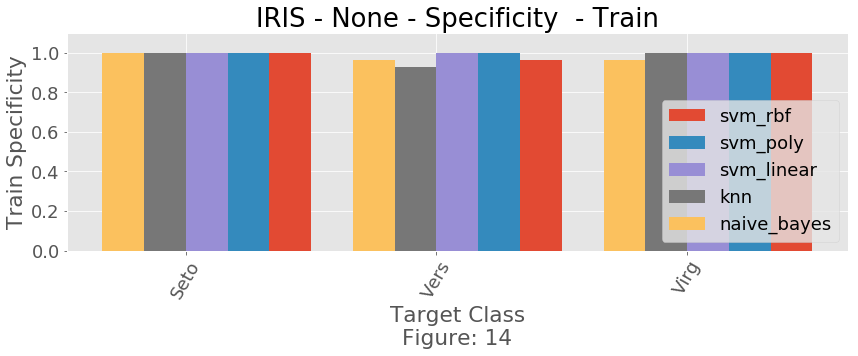

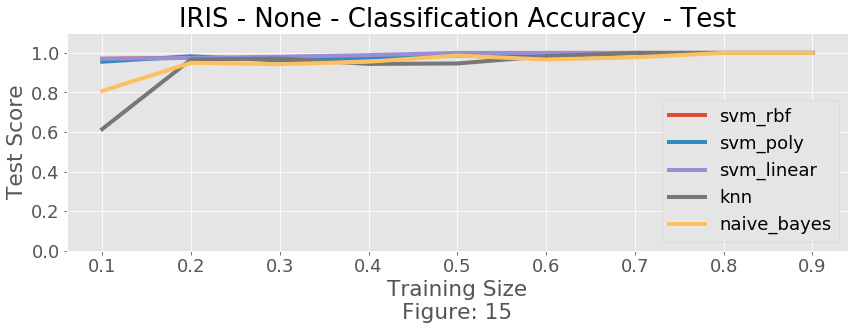

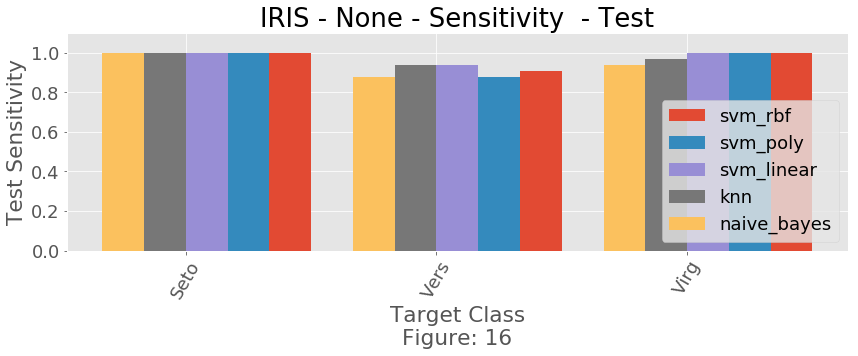

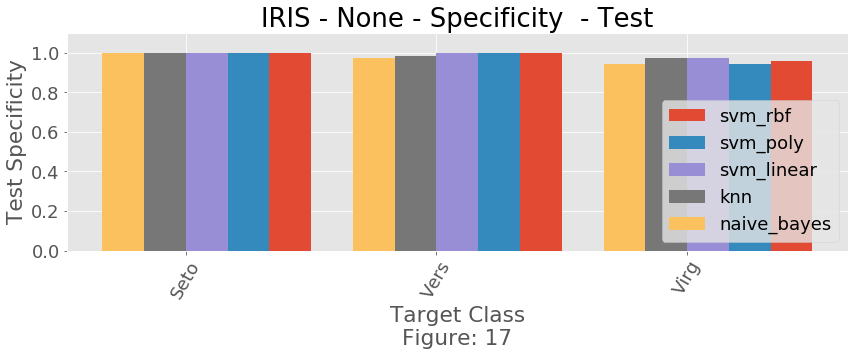

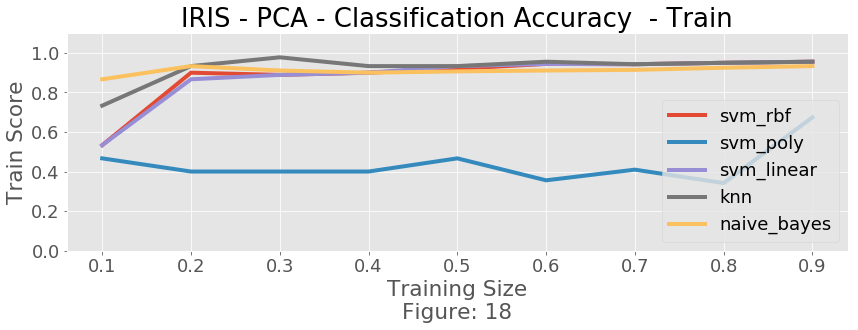

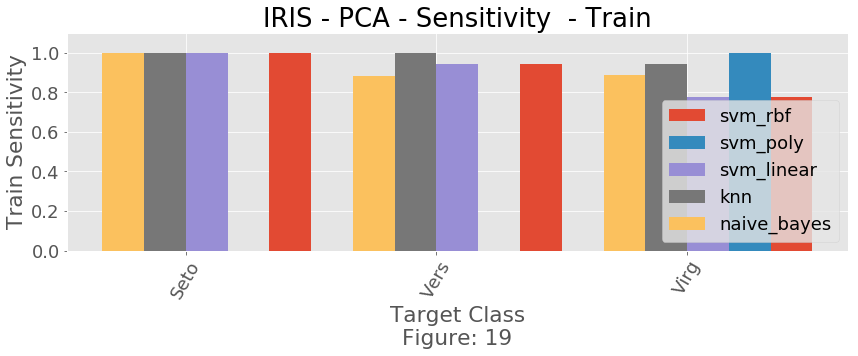

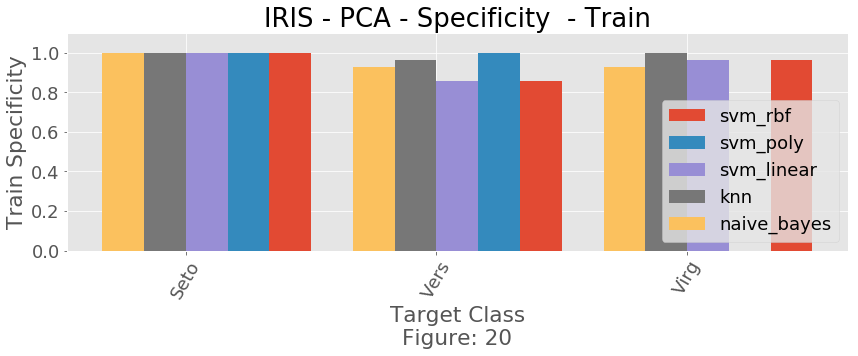

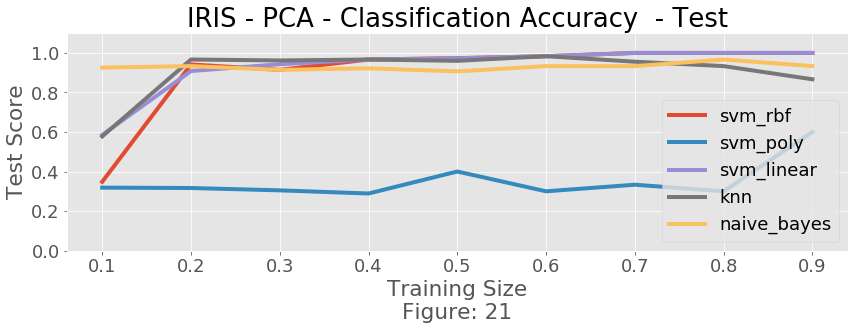

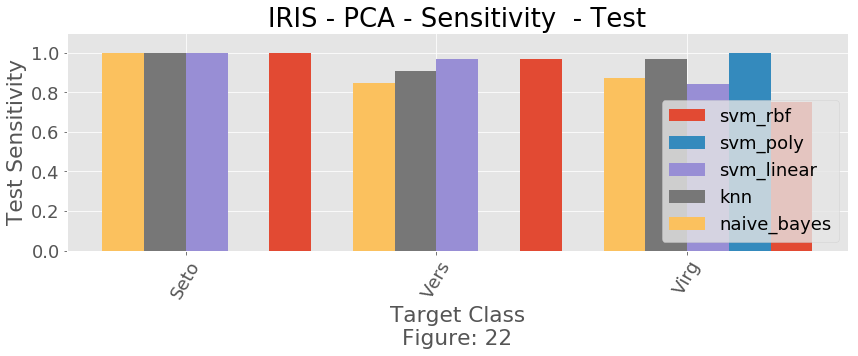

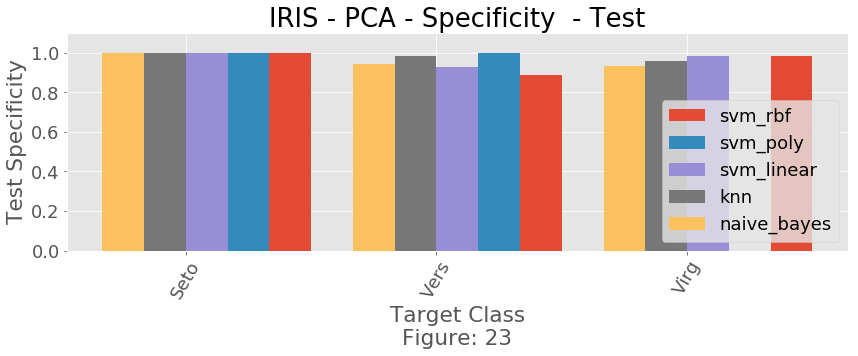

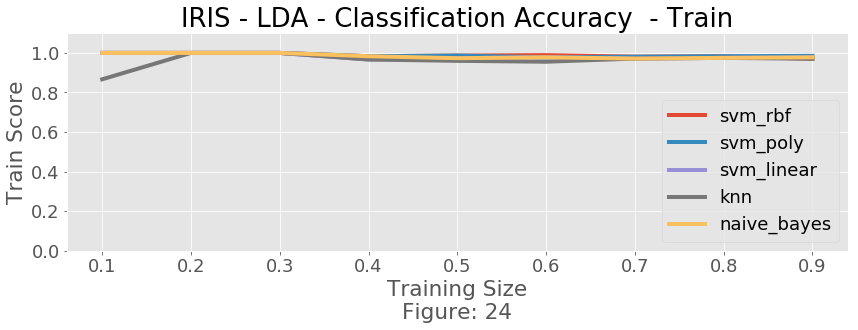

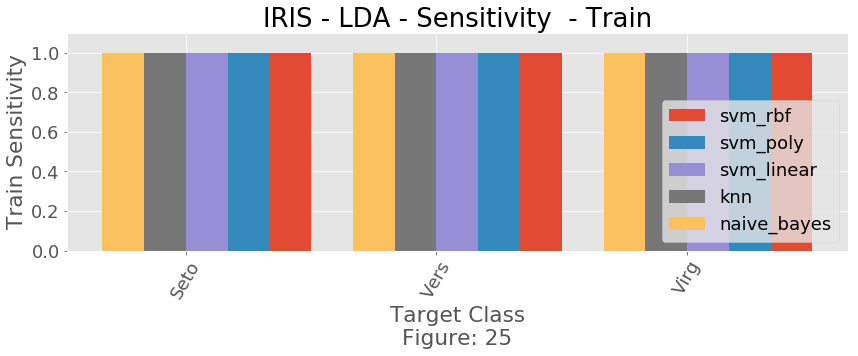

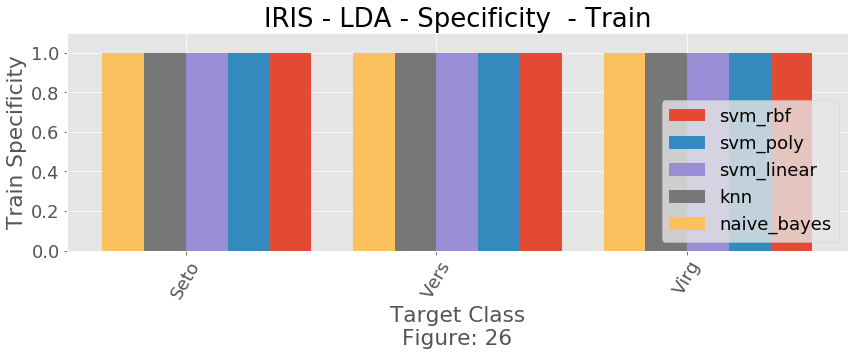

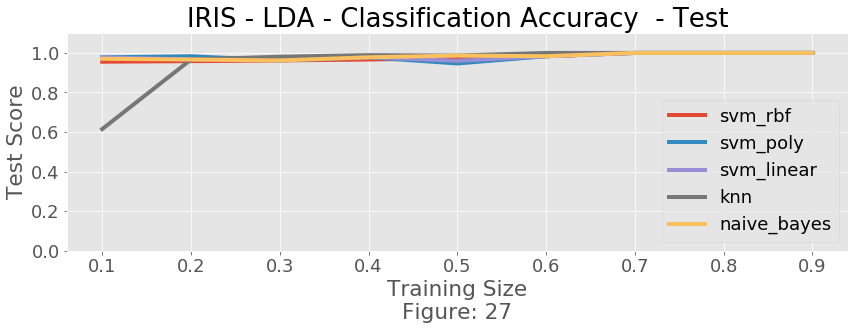

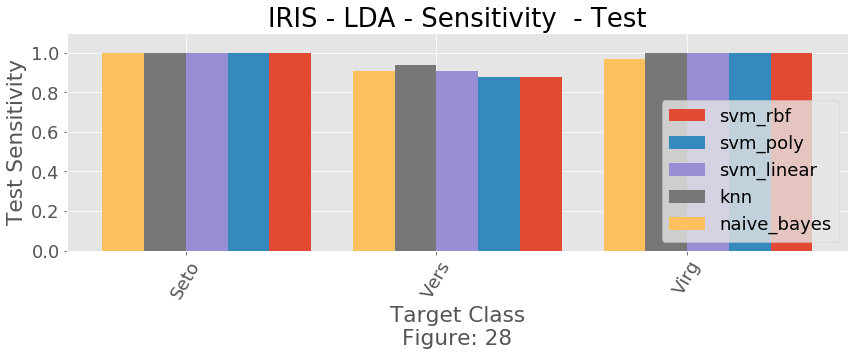

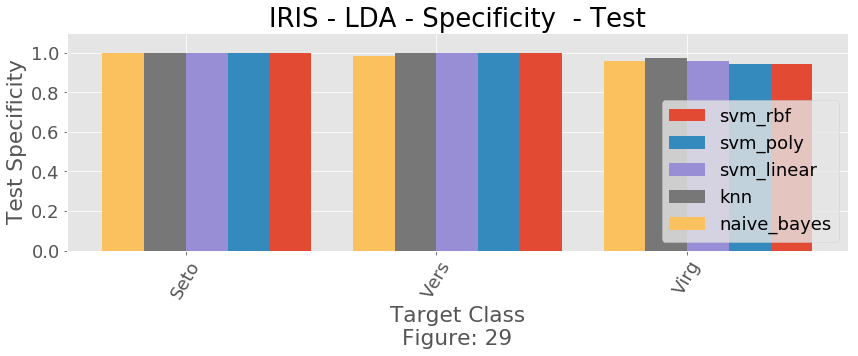

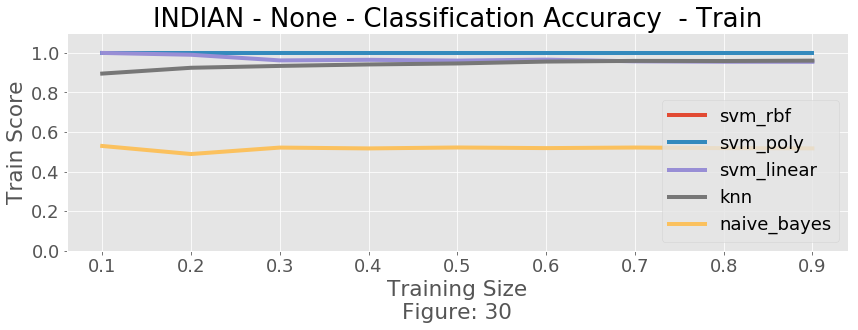

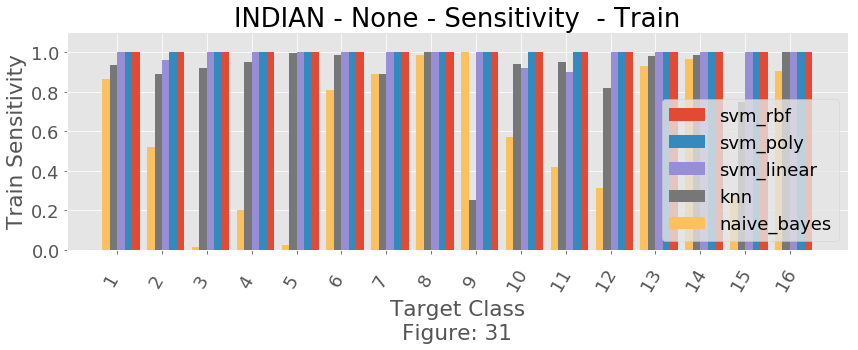

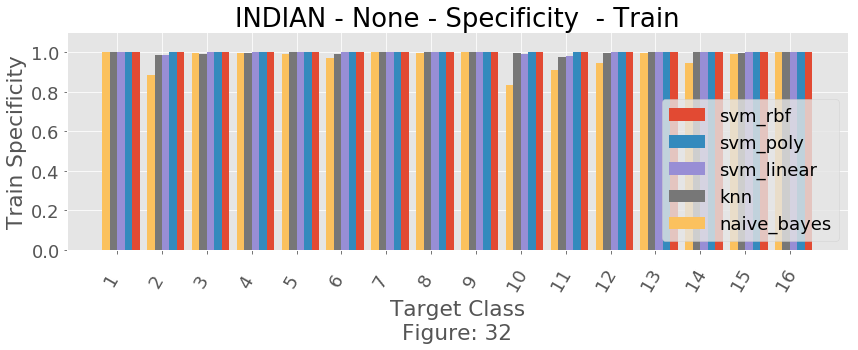

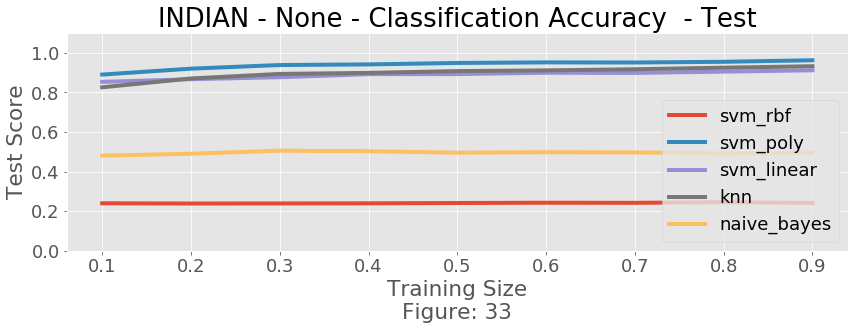

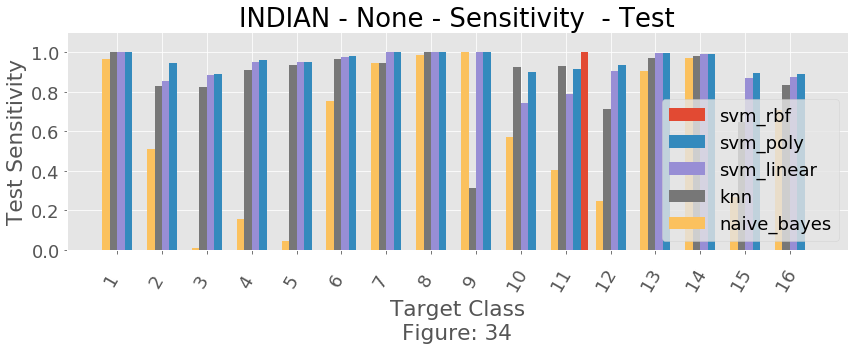

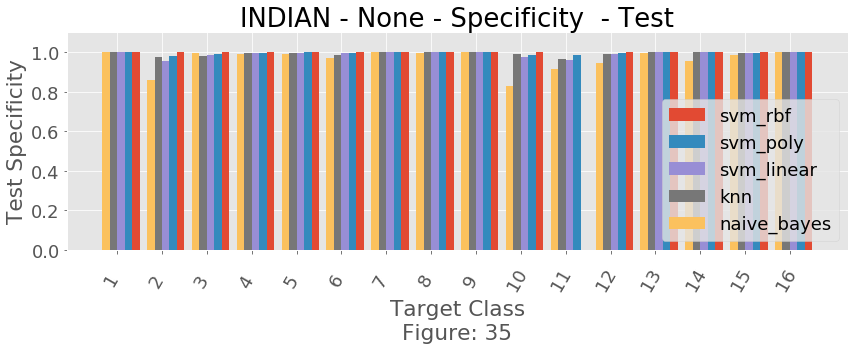

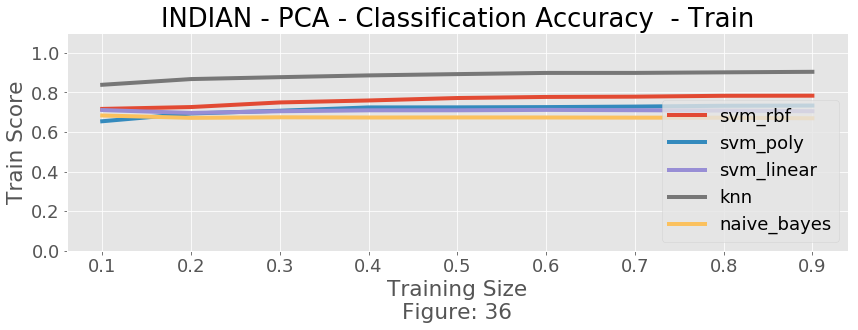

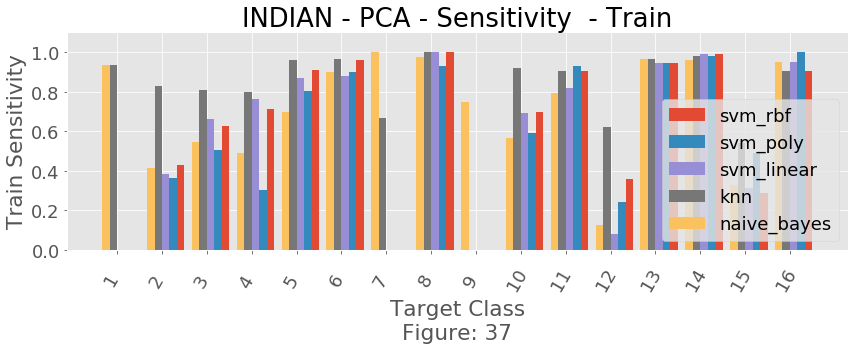

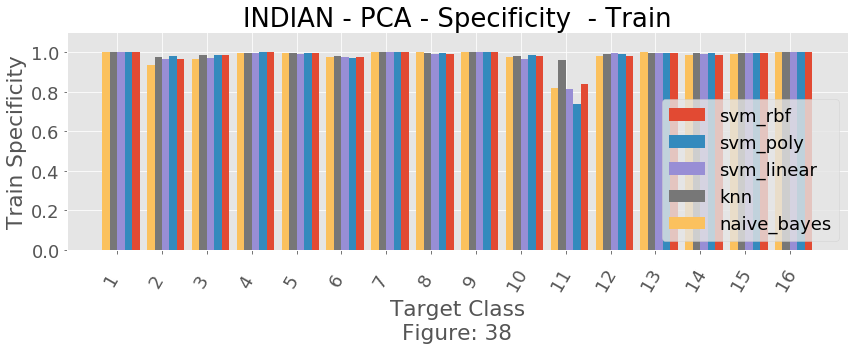

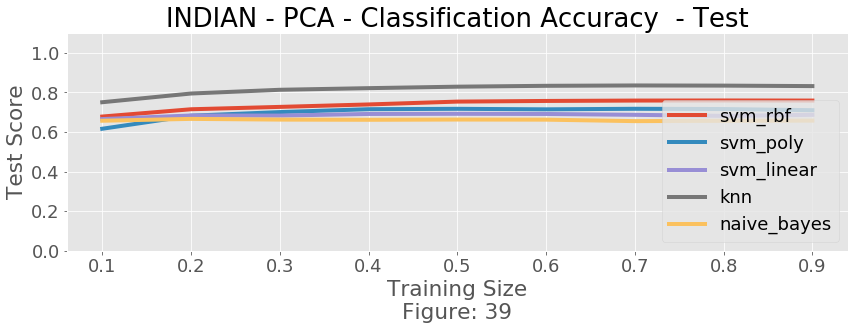

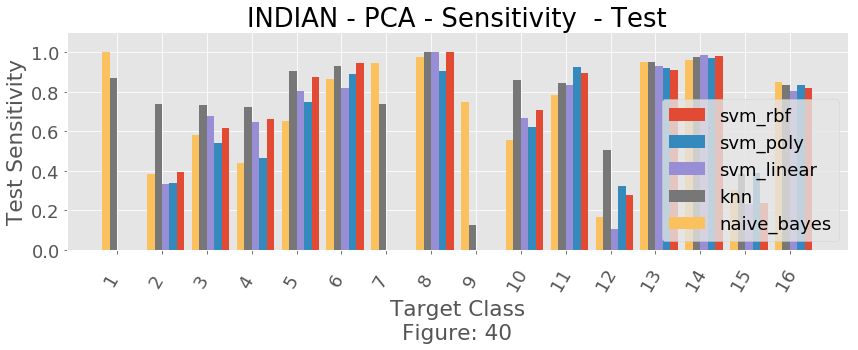

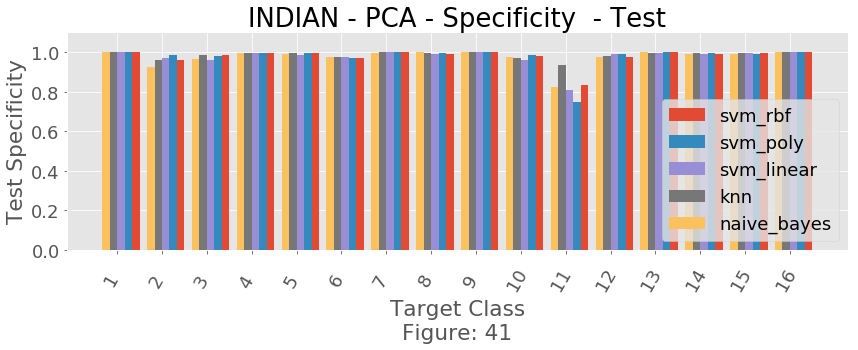

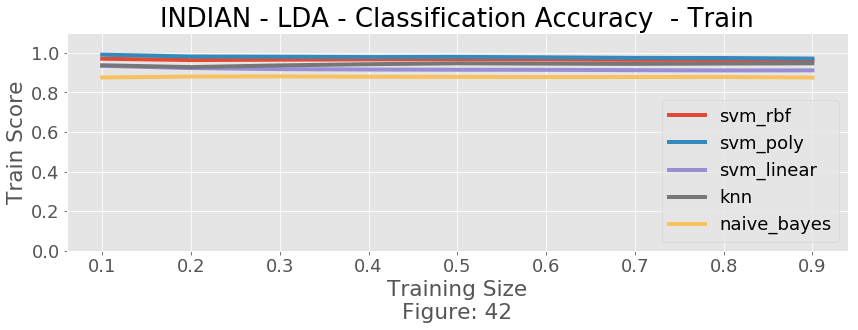

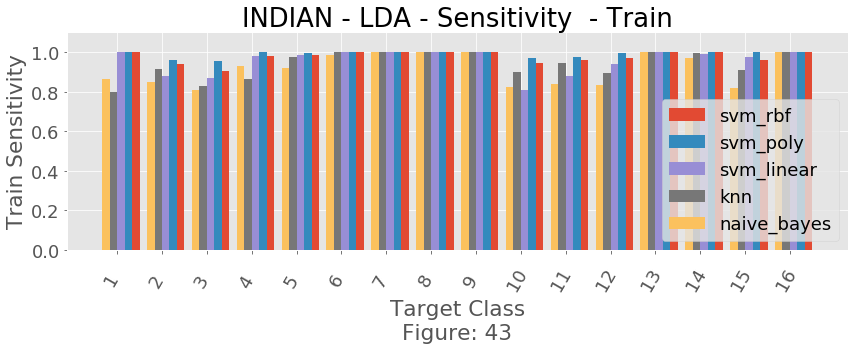

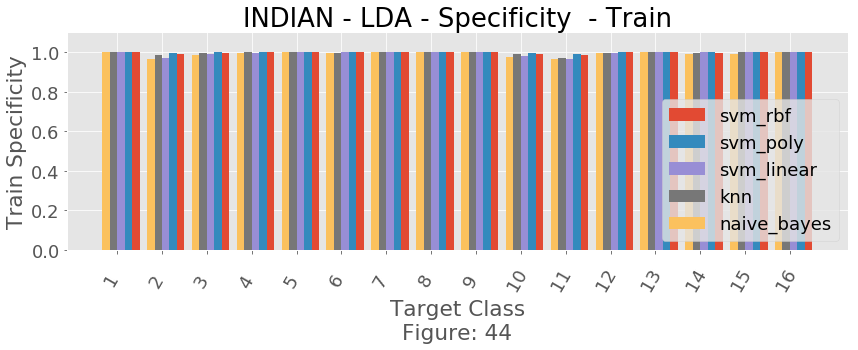

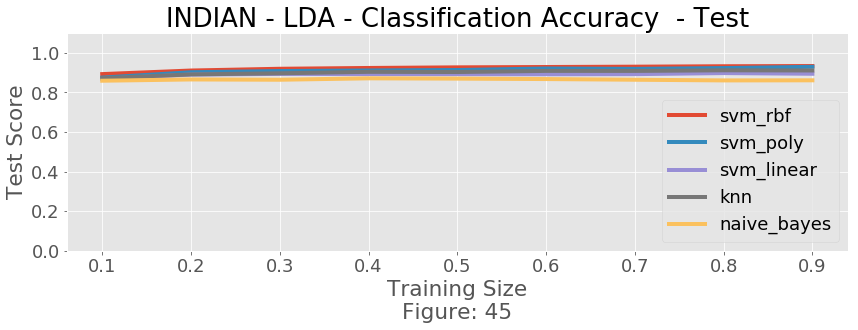

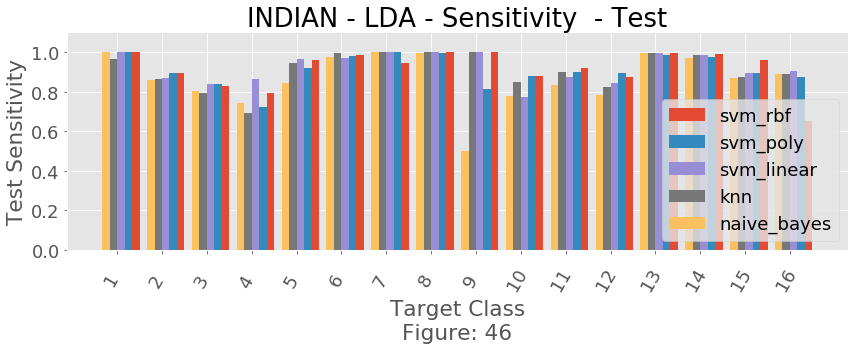

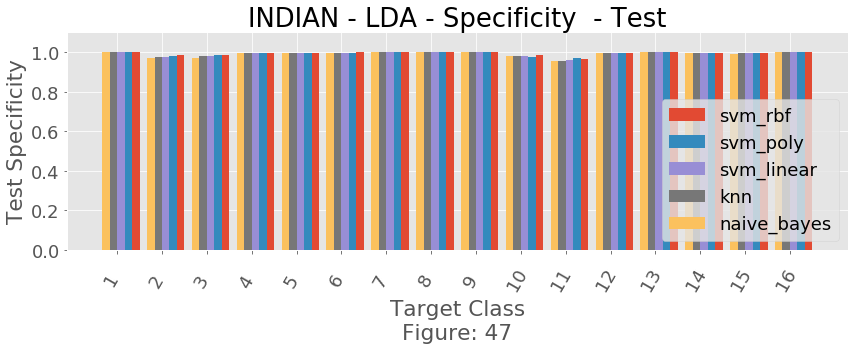

In [139]:
#loop over iris and indian datasets
for dataset in ["iris", "indian"]:
    # create our plot figure to add the various plots to
    # Three separate plots, first is classification accuracy, 
    # second is sensitiviity and third is specificity.
    # Plots will have 6 subplots, left column for train, right col for test
    # first row for no dimensionality reduction, second row for PCA, and third row for LDA
    fig_scores = []
    ax_scores = []
    fig_sens = []
    ax_sens = []
    fig_specs = []
    ax_specs = []
    for i in range(6):
        fig, ax = plt.subplots(figsize=(14,4))
        fig_scores.append(fig)
        ax_scores.append(ax)
        fig, ax = plt.subplots(figsize=(14,4))
        fig_sens.append(fig)
        ax_sens.append(ax)
        fig, ax = plt.subplots(figsize=(14,4))
        fig_specs.append(fig)
        ax_specs.append(ax)
    
    # add titles for all subplots
    for axes, output in [(ax_scores, "Classification Accuracy "), (ax_sens, "Sensitivity "), (ax_specs, "Specificity ")]:
        for axis, dim_reduction in zip(range(3), ["None", "PCA", "LDA"]):
            axes[2*axis].set_title(f"{dataset.upper()} - {dim_reduction} - {output} - Train")
            axes[2*axis+1].set_title(f"{dataset.upper()} - {dim_reduction} - {output} - Test")

    # loop over the dataframes for accessing the performance data in total_output dictionary
    for key, df in dfs.items():
        data, dim_red, dim_num = key.split("_")
        # determine correct row for the plots
        if data != dataset:
            continue
        if dim_red == "PCA":
            axis = 1
        elif dim_red == "LDA":
            axis = 2
        else:
            axis = 0
            
        #initialize arrays for performance plotting
        senss_train = []
        senss_test = []
        specs_train = []
        specs_test = []
        classifiers = []
        #loop over each classifier, and print the confusion matrix
        # also add the performance for each statistic of interest to our
        # initialized arrays
        #plot the classifier accuracy to our accuracy plots
        for classifier, model in models.items():
            run_output = total_output_pickle[key][classifier]
            if classifier == "svm_rbf" and dim_red == "LDA":
                print("============================================")
                print(get_header(data, dim_red, dim_num, classifier, 44))
                print("============================================")
                print(f"======       Train Size: 30%         =======")
                print("----      Training Confusion Matrix     ----")
                print_conf_mat(run_output["conf_mat_train"], run_output["targets"])
                print("----      Testing Confusion Matrix      ----")
                print_conf_mat(run_output["conf_mat_test"], run_output["targets"])
            
            label = f"{classifier}"
            # add accuracy to accuracy plot
            ax_scores[2*axis].plot(run_output["training_sizes"], 
                                    run_output["train_scores"], label=label, linewidth=4)
            ax_scores[2*axis+1].plot(run_output["training_sizes"], 
                                    run_output["test_scores"], label=label, linewidth=4)
            classifiers.append(classifier)
            senss_train.append(run_output["senss_train"][2,:])
            senss_test.append(run_output["senss_test"][2,:])
            specs_train.append(run_output["specs_train"][2,:])
            specs_test.append(run_output["specs_test"][2,:])
            
        #create X tick locations for the bar plots of sensitivity and specificity
        X = np.arange(1, len(run_output["targets"])+1)
        width = 1/(len(classifiers)+1)
        offset = width*(len(classifiers)//2) + width*(len(classifiers)%2)/2
        #loop over all the classifiers and add them to the sensitivity and specificity plots
        for iClassifier, classifier in enumerate(classifiers):
            ax_sens[2*axis].bar(X+offset-width*iClassifier, 
                                   senss_train[iClassifier], 
                                   label=classifier, 
                                   width=width)
            ax_sens[2*axis+1].bar(X+offset-width*iClassifier, 
                                   senss_test[iClassifier], 
                                   label=classifier, 
                                   width=width)
            ax_specs[2*axis].bar(X+offset-width*iClassifier, 
                                   specs_train[iClassifier], 
                                   label=classifier, 
                                   width=width)
            ax_specs[2*axis+1].bar(X+offset-width*iClassifier, 
                                   specs_test[iClassifier], 
                                   label=classifier, 
                                   width=width)
        targets = [""] + run_output["targets"]
        #rename xticks to target names
        for i in range(6):
            ax_sens[i].set_xticks(X)
            ax_specs[i].set_xticks(X)
            ax_sens[i].set_xticklabels(targets, Rotation=60)
            ax_specs[i].set_xticklabels(targets, Rotation=60)  
        
    # add proper ylimits, x and y labels and legends to plots
    for i in range(6):
        for axes, yax, xax in [(ax_scores, " Score", "Training Size"), 
                               (ax_sens, " Sensitivity", "Target Class"), 
                               (ax_specs, " Specificity", "Target Class")]:
        
            if i % 2:
                te_tr = "Test"
            else:
                te_tr = "Train"
            axes[i].set_ylim([0, 1.1])
            axes[i].legend(loc="lower right")
            axes[i].set_xlabel(f"{xax}\nFigure: {figure_count}")
            figure_count += 1
            axes[i].set_ylabel(te_tr + yax)
plt.show()

b)

iris) A PCA of 2 components and LDA of 2 components were chosen based on the information from question 1.

With the iris dataset, there is not a huge difference in performances and runtimes with and without data reduction (apart from the svm-poly on pca data). As long as the train size is over 20%, the performance reaches above 95%. In the end, it is up to personal preference on which learning method to use. Personally, I would choose LDA with 2 dimensions and use a simple knn model to predict. It is simple, easy to understand, fast and highly accurate for the iris dataset. The svm-poly dataset is completely failing with pca and I cannot determine why. It appears to select everything as Virginica (based on the confusion matrix). All the others perform adequately enough that I do not feel that it is necessary to alter the methods much to improve performance.

indian) Initially I used a PCA and LDA of only 4 components, but the results were not impressive so I upped the number of components to 10, then 15. The PCA has minimal improvement with increased components, so I stuck with 4 (which is what would be expected based on the results from question 1). The LDA saw about 5-10% improvement with increased components from 4 to 15. I ended up choosing 15 components as that uses all of the classes for LDA, and its runtime is still quite fast.

With the indian dataset, we see a much more noticable difference in performance and runtime based on dimensionality reduction. Without dimensionality reduction, the runtimes for the svm learners on the dataset are quite intensive. I would not use any of the svms on the unreduced data. The learners sensitivity versus target appear much improved with LDA vs PCA or no dimensionality reduction. The specificity seems to excel in most cases, except for the svm rbf and naive bayes with no dimensionality reduction in certain classes (class 11 being a bad instance) and svm poly appears to struggle in specificity with the PCA data. Based on the plots, PCA is not a good approach for the indian dataset for most learners (though it does seem to do quite well with knn). Most likely, there is significant overlap in the data (which is shown in the first question), and merely using variances to determine principal components is not enough. LDA is able to perform better because it takes into account target classes to try and maximize the interclass means and minimize intraclass variances. LDA appears to be the right approach as it has drastically faster runtimes and comparable performance with using the whole dataset. The best classifier in terms of classification accuracy is svm_rbf, but they all perform about the same and any of the choices should work based on the classification accuracy figures. Looking at specificicity and sensitivity, they all seem to do similar as well. Each learner seems to have one or two classes it particularly struggles with (ie. naive bayes struggles with class 9 in the indian dataset). An ensemble majority vote learner using knn, naive bayes and svm_rbf might be an interesting and more fruitful approach to combat this dilemma. 